# **Lab Internal - 2 (short codes)**

#7
Implement a Vanilla GAN and train it on a dataset like CIFAR-10

! (But performed on mnist dataset)

Epoch 1 - G Loss: 0.6517, D Loss: 1.2774


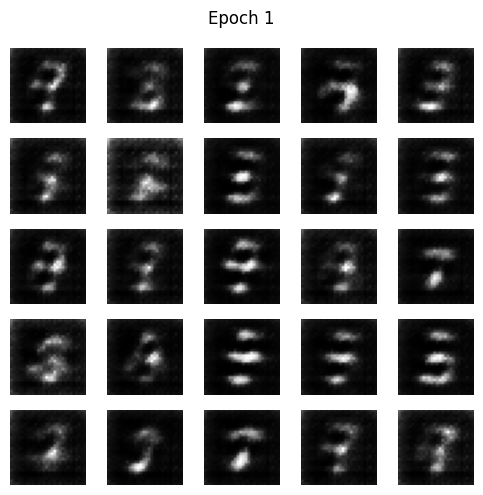

Epoch 5 - G Loss: 0.8217, D Loss: 1.4300


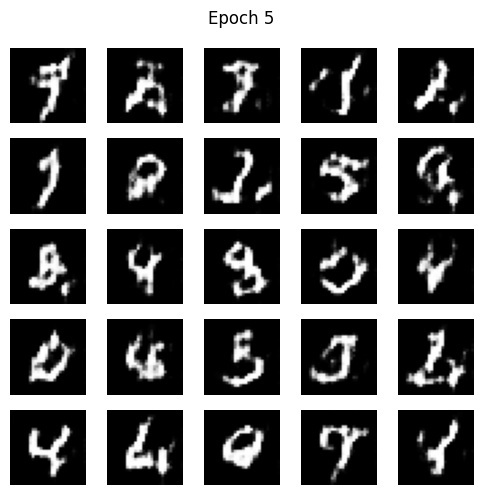

Training completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Config
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 5
BATCH_SIZE = 256
NOISE_DIM = 100
LR = 2e-4
BETA_1 = 0.5

# Data
(x_train, _), _ = keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

# Generator
def build_generator():
    return keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7,7,256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])

# Discriminator
def build_discriminator():
    return keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

generator = build_generator()
discriminator = build_discriminator()

# Losses & Optimizers
bce = keras.losses.BinaryCrossentropy()
g_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)
d_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)

def d_loss(real_out, fake_out):
    real_loss = bce(tf.ones_like(real_out)*0.9, real_out)  # label smoothing
    fake_loss = bce(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def g_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

# Training step
@tf.function
def train_step(real_imgs):
    noise = tf.random.normal([real_imgs.shape[0], NOISE_DIM])
    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake_imgs = generator(noise, training=True)
        real_out = discriminator(real_imgs, training=True)
        fake_out = discriminator(fake_imgs, training=True)
        gl = g_loss(fake_out)
        dl = d_loss(real_out, fake_out)
    g_grads = gt.gradient(gl, generator.trainable_variables)
    d_grads = dt.gradient(dl, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return gl, dl

# Plotting generated images
seed = tf.random.normal([25, NOISE_DIM])
def sample_images(epoch):
    preds = generator(seed, training=False)
    plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        img = (preds[i] + 1) / 2.0
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Training loop
def train():
    for epoch in range(1, EPOCHS+1):
        for real_batch in train_ds:
            gl, dl = train_step(real_batch)
        if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS:
            print(f'Epoch {epoch} - G Loss: {gl:.4f}, D Loss: {dl:.4f}')
            sample_images(epoch)

# Run
train()
print("Training completed!")


# 8
Implement Progressive GAN and train it on a dataset like MNIST


Training 8x8
Epoch 1: G=0.608 D=0.673
Epoch 2: G=0.621 D=0.684


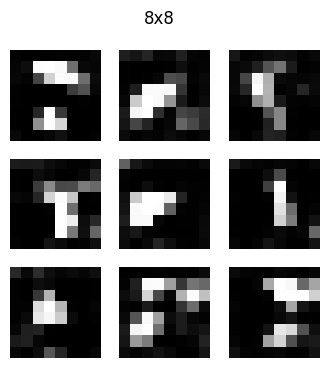


Training 16x16
Epoch 1: G=0.638 D=0.650
Epoch 2: G=0.707 D=0.666


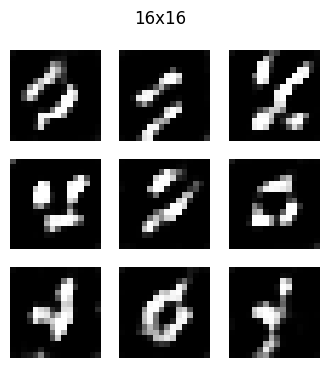


Training 32x32
Epoch 1: G=0.703 D=0.571
Epoch 2: G=0.796 D=0.652


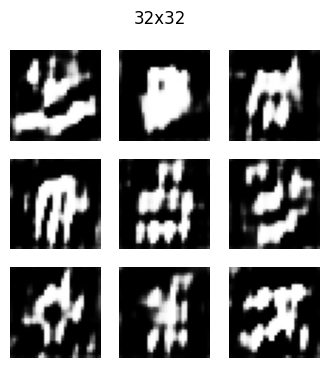


Training 64x64
Epoch 1: G=0.905 D=0.445
Epoch 2: G=1.009 D=0.579


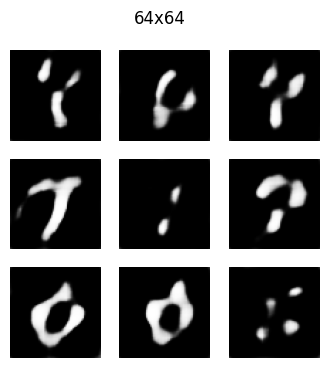

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

LATENT, BATCH, EPOCHS = 100, 64, 2
STAGES = [8, 16, 32, 64]

(x, _), _ = tf.keras.datasets.mnist.load_data()
x = (x.astype('float32') / 127.5 - 1)[..., None]

def G(r):
    m = tf.keras.Sequential([tf.keras.layers.Input((LATENT,)),
                             tf.keras.layers.Dense(4*4*128),
                             tf.keras.layers.Reshape((4,4,128))])
    c, f = 4, 128
    while c < r:
        m.add(tf.keras.layers.UpSampling2D())
        f = max(16, f//2)
        m.add(tf.keras.layers.Conv2D(f, 3, padding='same'))
        m.add(tf.keras.layers.LeakyReLU(0.2))
        c *= 2
    m.add(tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh'))
    return m

def D(r):
    m = tf.keras.Sequential([tf.keras.layers.Input((r,r,1))])
    f, c = 32, r
    while c > 4:
        m.add(tf.keras.layers.Conv2D(f, 3, padding='same'))
        m.add(tf.keras.layers.LeakyReLU(0.2))
        m.add(tf.keras.layers.AveragePooling2D(2))
        c //= 2
        f = min(256, f*2)
    m.add(tf.keras.layers.Flatten())
    m.add(tf.keras.layers.Dense(1, 'sigmoid'))
    return m

bce = tf.keras.losses.BinaryCrossentropy()

def train_step(G, D, real, g_opt, d_opt):
    z = tf.random.normal([real.shape[0], LATENT])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake = G(z, training=True)
        r_logit, f_logit = D(real, training=True), D(fake, training=True)
        g_loss = bce(tf.ones_like(f_logit), f_logit)
        d_loss = (bce(tf.ones_like(r_logit), r_logit) +
                  bce(tf.zeros_like(f_logit), f_logit)) / 2

    g_grads = g_tape.gradient(g_loss, G.trainable_variables)
    d_grads = d_tape.gradient(d_loss, D.trainable_variables)

    g_opt.apply_gradients(zip(g_grads, G.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, D.trainable_variables))

    return float(g_loss), float(d_loss)

for r in STAGES:
    print(f"\nTraining {r}x{r}")
    G_model, D_model = G(r), D(r)

    # Create new optimizers for each stage
    g_opt = tf.keras.optimizers.Adam(2e-4, 0.5)
    d_opt = tf.keras.optimizers.Adam(2e-4, 0.5)

    ds = tf.data.Dataset.from_tensor_slices(
        tf.image.resize(x, [r, r]).numpy()
    ).shuffle(10000).batch(BATCH)

    for epoch in range(EPOCHS):
        g_losses, d_losses = [], []
        for batch in ds.take(100):
            g_loss, d_loss = train_step(G_model, D_model, batch, g_opt, d_opt)
            g_losses.append(g_loss)
            d_losses.append(d_loss)
        print(f"Epoch {epoch+1}: G={np.mean(g_losses):.3f} D={np.mean(d_losses):.3f}")

    # Generate samples
    samples = (G_model(tf.random.normal([9, LATENT]), training=False).numpy() + 1) / 2
    fig, axes = plt.subplots(3, 3, figsize=(4, 4))
    for img, ax in zip(samples, axes.flat):
        ax.imshow(img[..., 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"{r}x{r}")
    plt.show()

# 9
Implement a style transfer algorithm using GANs and apply it to images

Follow these before running the code below :-

1.   Go to Kaggle and Login your account
2.   Go to Settings and Create New Token under API section
3.   It will download kaggle.json and upload it by running the first cell in this section
4.   It makes the session to download the dataset `pix2pix-dataset`


WorkFlow :-
Data Preparation → Model Construction → Adversarial Training → Image Generation

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json (from your Kaggle account)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip -q pix2pix-dataset.zip -d /content/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
License(s): unknown
 99% 2.37G/2.40G [00:30<00:00, 36.3MB/s]
100% 2.40G/2.40G [00:30<00:00, 83.8MB/s]


step 0 d:1.3912 g:47.2616
step 500 d:1.5085 g:20.6242
step 1000 d:0.8738 g:18.5207
step 1500 d:0.8194 g:20.1503
step 2000 d:0.6306 g:20.6037
step 2500 d:0.4554 g:21.4396
step 3000 d:0.6434 g:22.0877
step 3500 d:0.7080 g:19.4736
step 4000 d:0.4160 g:21.1887
step 4500 d:0.5690 g:20.2334


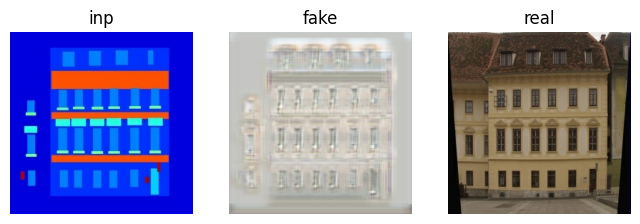

In [ ]:
import tensorflow as tf,os,matplotlib.pyplot as plt

IMG,BATCH=256,4
images_dir='/content/facades/facades/train'

def split(p):
    i=tf.image.decode_jpeg(tf.io.read_file(p),3)
    w=tf.shape(i)[1]//2
    a=tf.image.resize(tf.cast(i[:,w:,:],tf.float32)/255.,[IMG,IMG])
    b=tf.image.resize(tf.cast(i[:,:w,:],tf.float32)/255.,[IMG,IMG])
    return a,b

paths=[os.path.join(images_dir,f) for f in os.listdir(images_dir)]

ds=tf.data.Dataset.from_tensor_slices(paths).map(split).shuffle(512).batch(BATCH).prefetch(tf.data.AUTOTUNE)

def G():
    i=tf.keras.Input([IMG,IMG,3])
    x=tf.keras.layers.Conv2D(32,4,2,'same',activation='relu')(i)
    s1=x

    x=tf.keras.layers.Conv2D(64,4,2,'same',activation='relu')(x)
    s2=x

    x=tf.keras.layers.Conv2D(128,4,2,'same',activation='relu')(x)

    x=tf.keras.layers.UpSampling2D(2)(x)
    x=tf.keras.layers.Conv2D(64,3,1,'same',activation='relu')(x)
    x=tf.keras.layers.Concatenate()([x,s2])

    x=tf.keras.layers.UpSampling2D(2)(x)
    x=tf.keras.layers.Conv2D(32,3,1,'same',activation='relu')(x)
    x=tf.keras.layers.Concatenate()([x,s1])

    x=tf.keras.layers.UpSampling2D(2)(x)
    o=tf.keras.layers.Conv2D(3,3,1,'same',activation='tanh')(x)

    return tf.keras.Model(i,o)

def D():
    a=tf.keras.Input([IMG,IMG,3])
    b=tf.keras.Input([IMG,IMG,3])
    x=tf.keras.layers.Concatenate()([a,b])

    x=tf.keras.layers.Conv2D(32,4,2,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    x=tf.keras.layers.Conv2D(64,4,2,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    x=tf.keras.layers.Conv2D(128,4,1,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    o=tf.keras.layers.Conv2D(1,4,1,'same',activation='sigmoid')(x)

    return tf.keras.Model([a,b],o)

gen,disc=G(),D()

bce=tf.keras.losses.BinaryCrossentropy()
mae=tf.keras.losses.MeanAbsoluteError()

gopt=tf.keras.optimizers.Adam(2e-4,0.5)
dopt=tf.keras.optimizers.Adam(2e-4,0.5)

@tf.function
def step(inp,real,lam=100.0):
    with tf.GradientTape() as td:
        fake=gen(inp,training=True)
        ro=disc([inp,real],training=True)
        fo=disc([inp,fake],training=True)
        dl=bce(tf.ones_like(ro),ro)+bce(tf.zeros_like(fo),fo)

    dopt.apply_gradients(zip(td.gradient(dl,disc.trainable_variables),disc.trainable_variables))

    with tf.GradientTape() as tg:
        fake=gen(inp,training=True)
        fo=disc([inp,fake],training=False)
        gl=bce(tf.ones_like(fo),fo)+lam*mae(real,fake)

    gopt.apply_gradients(zip(tg.gradient(gl,gen.trainable_variables),gen.trainable_variables))

    return dl,gl

it=iter(ds.repeat())
# Train longer
for s in range(5000):  # instead of 200
    x, y = next(it)
    dl, gl = step(x, y)
    if s % 500 == 0:
        print(f"step {s} d:{dl.numpy():.4f} g:{gl.numpy():.4f}")

x,y=next(iter(ds));f=gen(x,training=False)

plt.figure(figsize=(8,4));plt.subplot(1,3,1);plt.imshow(x[0]);plt.axis('off');plt.title('inp')
plt.subplot(1,3,2);plt.imshow((f[0]*0.5)+0.5);plt.axis('off');plt.title('fake')
plt.subplot(1,3,3);plt.imshow(y[0]);plt.axis('off');plt.title('real')
plt.show()


# 10
Implement a basic transformer model using PyTorch or TensorFlow and train it on a text dataset like WikiText-2 for language modeling.

! (But performed on custom dataset)

WorkFlow :-

Raw Text → Tokenized Sequences → Padded Arrays →
Embeddings → Transformer Processing →
Next-Word Predictions → Generated Text

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

texts = [
    "machine learning is fascinating and powerful",
    "deep learning is a subset of machine learning",
    "neural networks can learn complex patterns",
    "transformers are great for natural language processing",
    "language models can generate realistic text"
]

corpus = " ".join(texts)
tokens = corpus.lower().split()
vocab = sorted(set(tokens))
word_index = {w: i + 1 for i, w in enumerate(vocab)}
index_word = {i + 1: w for i, w in enumerate(vocab)}
vocab_size = len(vocab) + 1

input_sequences = []
target_sequences = []
for i in range(1, len(tokens)):
    input_sequences.append([word_index[w] for w in tokens[:i]])
    target_sequences.append([word_index[w] for w in tokens[1:i+1]])

max_len = max(len(s) for s in input_sequences)
X = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_len, padding="pre")
y = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_len, padding="pre")

class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, max_len, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)

    def call(self, x):
        positions = tf.range(tf.shape(x)[-1])
        return self.token_emb(x) + self.pos_emb(positions)

def transformer_block(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(embed_dim)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x + ffn)

def build_transformer_lm(vocab_size, seq_length, embed_dim=64, num_heads=2, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=(seq_length,))
    x = PositionalEmbedding(vocab_size, seq_length, embed_dim)(inputs)
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = build_transformer_lm(vocab_size, X.shape[1])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
model.fit(X, y, epochs=100, batch_size=16, verbose=1)

def generate_text(seed_text, num_words=10):
    for _ in range(num_words):
        token_list = [word_index.get(w, 0) for w in seed_text.split()]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=X.shape[1], padding="pre")
        preds = model.predict(token_list, verbose=0)
        predicted = int(np.argmax(preds[0, -1, :]))
        seed_text += " " + index_word.get(predicted, "")
    return seed_text

print("\n--- Text Generation ---")
print(generate_text("machine learning is", num_words=25))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 32, 64)    │      3,840 │ input_layer_3[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 64)    │     33,216 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 64)    │          0 │ positional_embed… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32, 64)    │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32, 64)    │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32, 28)    │      1,820 │ layer_normalizat

 Total params: 105,756 (413.11 KB)

 Trainable params: 105,756 (413.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2363 - loss: 3.0153
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5547 - loss: 1.5126
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6986 - loss: 1.0101
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8529 - loss: 0.7204
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9193 - loss: 0.4676
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9401 - loss: 0.3116
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9466 - loss: 0.2480
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9499 - loss: 0.2053
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9460 - loss: 0.1750
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9499 - loss: 0.1573
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9518 - loss: 0.1450
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9486 - l

# 11
Fine-tune a pre-trained GPT model on a specific task such as sentiment analysis using a dataset like IMDB reviews.

! (But performed on custom dataset)

WorkFlow :-

Raw Text
    ->
Tokenizer (GPT2Tokenizer)
    ->
{'input_ids': [tensor], 'attention_mask': [tensor]}
    ->
TF Dataset (batched, shuffled)
    ->
DistilGPT2 Model
    ->
Logits [batch_size, 2]
    ->
SparseCategoricalCrossentropy
    ->
Training Updates

In [ ]:

import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2ForSequenceClassification
texts = [
 "I love this movie, it was fantastic!",
 "Absolutely wonderful experience, would recommend!",
 "Terrible movie, I hated every moment.",
 "Worst film ever, waste of time.",
 "The acting was brilliant and touching.",
 "Awful plot and bad direction.",
 "A great story and strong performances.",
 "It was boring and too long."
]
labels = [1,1,0,0,1,0,1,0]
trn_texts, tst_texts = texts[:6], texts[6:]
trn_labels, tst_labels = labels[:6], labels[6:]
mname = "distilgpt2"
tok = GPT2Tokenizer.from_pretrained(mname)
tok.pad_token = tok.eos_token
def enc(txts):
    return tok(txts, truncation=True, padding=True, max_length=64, return_tensors="tf")
trn_enc = enc(trn_texts)
tst_enc = enc(tst_texts)
trn_ds = tf.data.Dataset.from_tensor_slices((dict(trn_enc), trn_labels)).shuffle(6).batch(2)
tst_ds = tf.data.Dataset.from_tensor_slices((dict(tst_enc), tst_labels)).batch(2)

model = TFGPT2ForSequenceClassification.from_pretrained(mname, num_labels=2, from_pt=True)
model.config.pad_token_id = tok.eos_token_id
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.fit(trn_ds, validation_data=tst_ds, epochs=3)
print("Eval:", model.evaluate(tst_ds))
def predict(text):
    e = tok(text, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(e).logits
    p = int(tf.argmax(logits, axis=-1).numpy()[0])
    return "Positive 😀" if p==1 else "Negative 😠"
for ex in ["The movie was absolutely amazing!","It was dull and disappointing.","The plot was okay, but the acting was weak."]:
    print(ex,"->",predict(ex))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


pytorch_model.bin:   0%|          | 0.00/353M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-str

Epoch 1/3
3/3 [==============================] - 25s 792ms/step - loss: 2.4038 - accuracy: 0.1667 - val_loss: 1.3432 - val_accuracy: 0.5000
Epoch 2/3
3/3 [==============================] - 0s 39ms/step - loss: 1.0861 - accuracy: 0.5000 - val_loss: 0.8552 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 0.7617 - accuracy: 0.5000
Eval: [0.7616574168205261, 0.5]
The movie was absolutely amazing! -> Negative 😠
It was dull and disappointing. -> Negative 😠
The plot was okay, but the acting was weak. -> Negative 😠
